In [1]:
import pandas as pd
import numpy as np
import holidays
import lightgbm as lgb
import joblib
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train = pd.read_csv('train_aWnotuB.csv')
test = pd.read_csv('test_BdBKkAj.csv')

In [3]:
train.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DateTime  48120 non-null  object
 1   Junction  48120 non-null  int64 
 2   Vehicles  48120 non-null  int64 
 3   ID        48120 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


In [5]:
train.describe()

,Junction,Vehicles,ID
count,48120.000000,48120.000000,4.812000e+04
mean,2.180549,22.791334,2.016330e+10
std,0.966955,20.750063,5.944854e+06
min,1.000000,1.000000,2.015110e+10
25%,1.000000,9.000000,2.016042e+10
50%,2.000000,15.000000,2.016093e+10
75%,3.000000,29.000000,2.017023e+10
max,4.000000,180.000000,2.017063e+10


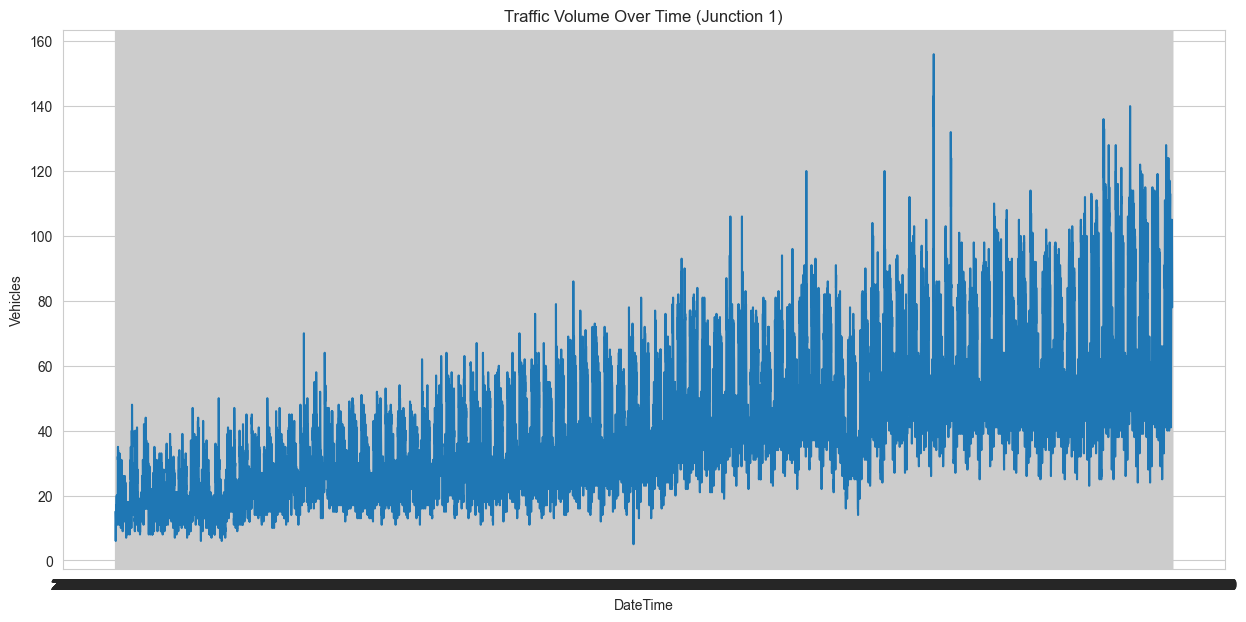

In [6]:
sns.set_style("whitegrid")
plt.figure(figsize=(15, 7))
sns.lineplot(data=train[train['Junction']==1], x='DateTime', y='Vehicles')
plt.title('Traffic Volume Over Time (Junction 1)')
plt.show()

In [7]:
def create_time_features(df):
    df['DateTime'] = pd.to_datetime(df['DateTime'])
    df['hour'] = df['DateTime'].dt.hour
    df['day'] = df['DateTime'].dt.day
    df['dayofweek'] = df['DateTime'].dt.dayofweek
    df['month'] = df['DateTime'].dt.month
    df['year'] = df['DateTime'].dt.year
    df['dayofyear'] = df['DateTime'].dt.dayofyear
    df['weekofyear'] = df['DateTime'].dt.isocalendar().week.astype(int)
    india_holidays = holidays.country_holidays('IN', years=[2015, 2016, 2017])
    df['is_holiday'] = df['DateTime'].dt.date.apply(lambda x: x in india_holidays).astype(int)
    df['is_weekend'] = df['dayofweek'].apply(lambda x: 1 if x in [5, 6] else 0)

    return df

In [8]:
train = create_time_features(train)
test = create_time_features(test)

C:\Users\Adarsh\AppData\Local\Temp\ipykernel_19064\2986171125.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Junction', y='Vehicles', data=train, palette='magma')


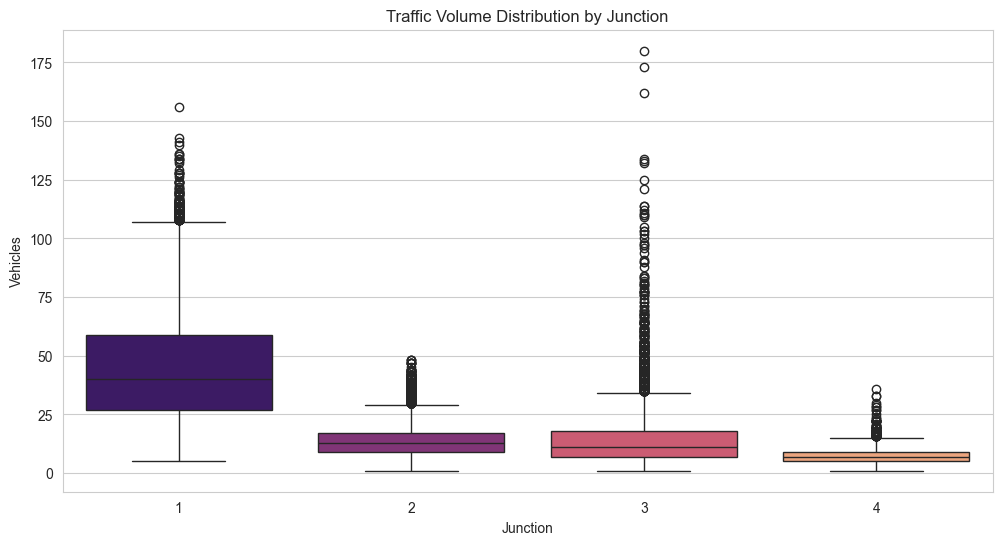

In [9]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Junction', y='Vehicles', data=train, palette='magma')
plt.title('Traffic Volume Distribution by Junction')
plt.show()

C:\Users\Adarsh\AppData\Local\Temp\ipykernel_19064\999578523.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='is_holiday', y='Vehicles', data=train, palette='coolwarm')


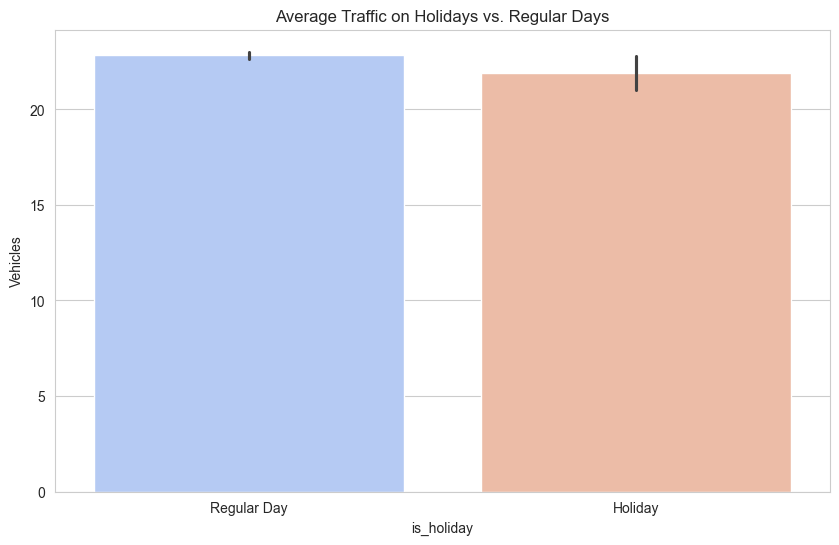

In [10]:
plt.figure(figsize=(10, 6))
sns.barplot(x='is_holiday', y='Vehicles', data=train, palette='coolwarm')
plt.title('Average Traffic on Holidays vs. Regular Days')
plt.xticks([0, 1], ['Regular Day', 'Holiday'])
plt.show()

In [11]:
train = pd.get_dummies(train, columns=['Junction'])
test = pd.get_dummies(test, columns=['Junction'], prefix='Junction')

In [12]:
train = train.sort_values('DateTime')
split_date = '2017-04-01'
val_df = train[train['DateTime'] >= split_date]
train_df = train[train['DateTime'] < split_date]

In [13]:
features = [col for col in train.columns if col not in ['ID', 'DateTime', 'Vehicles']]
target = 'Vehicles'

In [14]:
X_train, y_train = train_df[features], train_df[target]
X_val, y_val = val_df[features], val_df[target]

In [15]:
lgbm = lgb.LGBMRegressor(random_state=42)
lgbm.fit(X_train, y_train)
lgbm_preds = lgbm.predict(X_val)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001203 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 39384, number of used features: 13
[LightGBM] [Info] Start training from score 21.334374


In [16]:
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, min_samples_leaf=5)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_val)

In [17]:
print("LightGBM R2 Score:", r2_score(y_val, lgbm_preds))
print("LightGBM RMSE:", np.sqrt(mean_squared_error(y_val, lgbm_preds)))
print("-" * 20)
print("Random Forest R2 Score:", r2_score(y_val, rf_preds))
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_val, rf_preds)))
print("-" * 20)

LightGBM R2 Score: 0.9202671697390754
LightGBM RMSE: 7.742969403718845
--------------------
Random Forest R2 Score: 0.9208520595691274
Random Forest RMSE: 7.7145173845969035
--------------------


In [18]:
final_model = rf

In [19]:
final_model.fit(train[features], train[target])

RandomForestRegressor(min_samples_leaf=5, n_jobs=-1, random_state=42)

In [20]:
joblib.dump(final_model, 'traffic_model_rf.pkl')

['traffic_model_rf.pkl']

In [21]:
test_preds = final_model.predict(test[features])
submission = pd.DataFrame({'ID': test['ID'], 'Vehicles': test_preds})
submission['Vehicles'] = submission['Vehicles'].apply(lambda x: int(max(0, x))) # Make sure vehicles are positive integers
submission.to_csv('submission.csv', index=False)
